# Обнаружение пожаров по фото и видео

In [1]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# import the necessary packages
# in anaconda prompt:conda install tensorflow or pip install tensorflow
# in anaconda prompt:conda install keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import argparse
import sys

In [2]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [3]:
#in anaconda prompt:pip install opencv-python 
import cv2

In [4]:
#in anaconda prompt: conda config --set allow_conda_downgrades true
#in anaconda prompt: conda install conda=4.6.14
#in anaconda prompt: conda install -c conda-forge imutils
from imutils import paths

In [5]:
# чтение файлов и структуры директорий
import os

## Подготовка данных

In [6]:
FIRE_PATH = "C:/Users/Marinka/Desktop/pract/fire-detection/fire"
NO_FIRE_PATH = "C:/Users/Marinka/Desktop/pract/fire-detection/nofire"

In [7]:
# инициализировать метки классов в наборе данных
CLASSES_NAMES = ["NoFire", "Fire"]

In [8]:
# функция, которая принимает путь к набору данных
def load_dataset(datasetPath):
    # путь к изображениям
    imagePaths = list(paths.list_images(datasetPath))
    data = []

    for imagePath in imagePaths:
        # загрузка изображений и изменение их размеров до 128x128 пикселей, 
        # игнорируя соотношение сторон
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (128, 128))

        # добавить изображение в список data
        data.append(image)

    # array возвращает список data  в формате массива NumPy
    return np.array(data, dtype="float32")

In [9]:
import numpy as np
# загрузка изображений с огнем и без огня
fireData = load_dataset(FIRE_PATH)
noFireData = load_dataset(NO_FIRE_PATH)

# конструирование меток для классов, 1 - пожар, 0 -нет пожара
fireLabels = np.ones((fireData.shape[0],))
noFireLabels = np.zeros((noFireData.shape[0],))

# функция vstack() соединяет массивы по вертикали
data = np.vstack([fireData, noFireData])
# функция hstack() соединяет массивы по горизонтали
labels = np.hstack([fireLabels, noFireLabels])

# масштабировать интенсивность пикселей до диапазона [0, 1]
data /= 255

In [10]:
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [11]:
# преобразование правильных ответов в формат one hot encoding
labels = to_categorical(labels, num_classes=2)

In [12]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [13]:
# создание баланса
classTotal= labels.sum(axis=0) # cуммируются значения по оси 0 (по столбцам)
classWeight = classTotal.max() / classTotal

In [14]:
classTotal# [количество изображений без огня, с огнем]

array([2688., 1472.], dtype=float32)

In [15]:
classTotal.max()# больше изображений без огня

2688.0

In [16]:
classWeight# больший вес назначается изображениям с огнем, тк их меньше

array([1.      , 1.826087], dtype=float32)

In [17]:
# размер выборки валидации
VAL_SIZE = 0.2

In [18]:
# разделение на выборку для обучения и выборку для валидации
#x_train -изображения, y_train -метки для обозначения класса
(x_train, x_val, y_train, y_val) = train_test_split(data, labels,
    test_size=VAL_SIZE, 
    random_state=42
  )

## Создание нейронной сети

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D, Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [20]:
# DCNN
model = Sequential()
inputShape = (128, 128, 3)
chanDim = -1

# CONV -> CONV -> CONV ->POOL
# Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding="same", 
     input_shape=inputShape))
model.add(Activation("relu"))
# Пакетная нормализация 
model.add(BatchNormalization(axis=chanDim)) 
# Второй сверточный слой
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
# Пакетная нормализация 
model.add(BatchNormalization(axis=chanDim)) 
# Третий сверточный слой
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
# Пакетная нормализация 
model.add(BatchNormalization(axis=chanDim)) 
# Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))


# CONV -> CONV -> POOL
# Четвертый сверточный слой
model.add(Conv2D(64, (3, 3), padding="same")) 
model.add(Activation("relu"))
#Пакетная нормализация
model.add(BatchNormalization(axis=chanDim))
# Пятый сверточный слой
model.add(Conv2D(64, (3, 3), padding="same")) 
model.add(Activation("relu"))
#Пакетная нормализация
model.add(BatchNormalization(axis=chanDim))
# Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))

# CONV -> CONV -> POOL
# Шестой сверточный слой
model.add(Conv2D(128, (3, 3), padding="same")) 
model.add(Activation("relu"))
#Пакетная нормализация
model.add(BatchNormalization(axis=chanDim))
# Седьмой сверточный слой
model.add(Conv2D(128, (3, 3), padding="same")) 
model.add(Activation("relu"))
#Пакетная нормализация
model.add(BatchNormalization(axis=chanDim))
# Третий слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))

# CONV -> CONV -> POOL
# Восьмой сверточный слой
model.add(Conv2D(256, (3, 3), padding="same")) 
model.add(Activation("relu"))
#Пакетная нормализация
model.add(BatchNormalization(axis=chanDim))
# Девятый сверточный слой
model.add(Conv2D(256, (3, 3), padding="same")) 
model.add(Activation("relu"))
#Пакетная нормализация
model.add(BatchNormalization(axis=chanDim))
# Четвертый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))

# СLASSIFIER
# Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
# Первый полносвязный слой для классификации
model.add(Dense(512))
model.add(Activation("relu"))
# Пакетная нормализация
model.add(BatchNormalization())
# Слой регуляризации Dropout
model.add(Dropout(0.5))
# Второй полносвязный слой
model.add(Dense(512))
model.add(Activation("relu"))
# Пакетная нормализация
model.add(BatchNormalization())
# Слой регуляризации Dropout
model.add(Dropout(0.5))
# Выходной слой
model.add(Dense(2))
model.add(Activation("softmax"))

## ImageDataGenerator

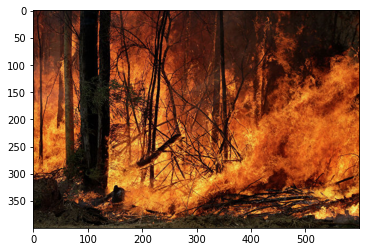

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imread, imshow, subplots, show

def plot(data_generator):
    data_generator.fit(images)
    image_iterator = data_generator.flow(images)
    
    # Plot the images given by the iterator
    fig, rows = subplots(nrows=1, ncols=4, figsize=(18,18))
    for row in rows:
        row.imshow(image_iterator.next()[0].astype('int'))
        row.axis('off')
    show()
    
image = imread('C:/Users/Marinka/Desktop/pract/fire-detection/test/1.jpg')

# Creating a dataset which contains just one image.
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

imshow(images[0])
show()


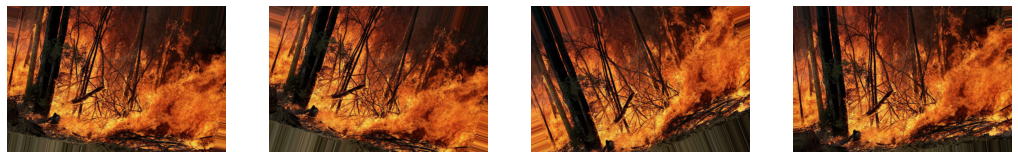

In [22]:
# поворот
data_generator = ImageDataGenerator(rotation_range=25)
plot(data_generator)

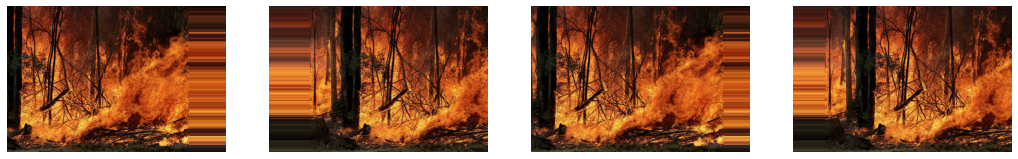

In [23]:
# сдвиг по гор-ли
data_generator = ImageDataGenerator(width_shift_range=0.2)
plot(data_generator)

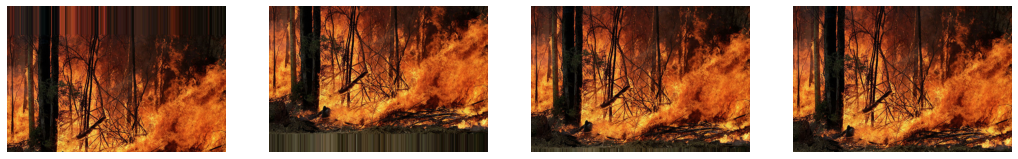

In [24]:
# сдвиг по вертикали
data_generator = ImageDataGenerator(height_shift_range=0.2)
plot(data_generator)

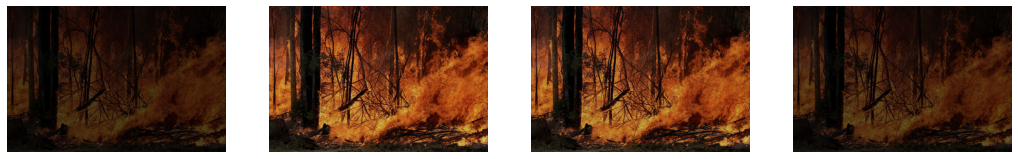

In [25]:
# Яркость
data_generator = ImageDataGenerator(brightness_range=(0.1, 0.9))
plot(data_generator)

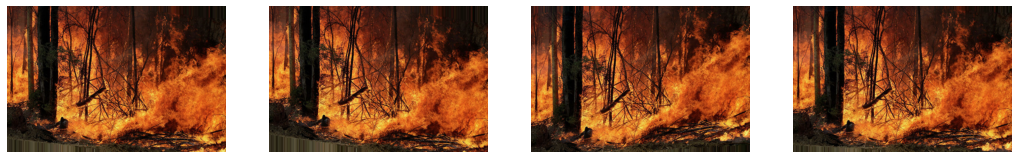

In [26]:
# Интенсивность сдвига
data_generator = ImageDataGenerator(shear_range=10)
plot(data_generator)

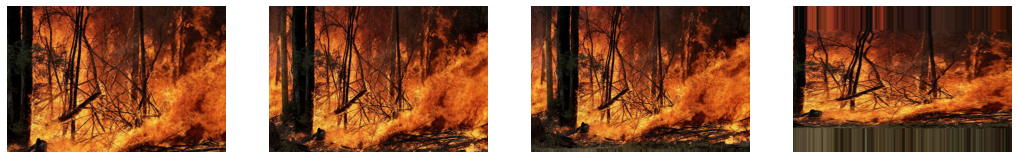

In [27]:
# зум
data_generator = ImageDataGenerator(zoom_range=[0.5, 1.5])
plot(data_generator)

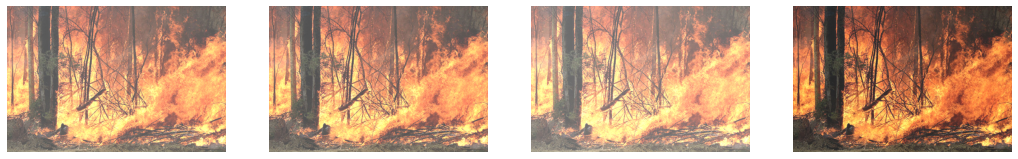

In [28]:
# сдвиг канала
data_generator = ImageDataGenerator(channel_shift_range=150.0)
plot(data_generator)

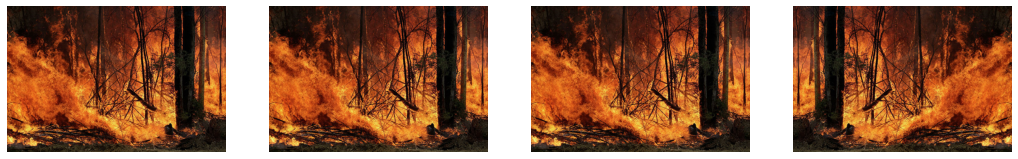

In [29]:
data_generator = ImageDataGenerator(horizontal_flip=True)
plot(data_generator)

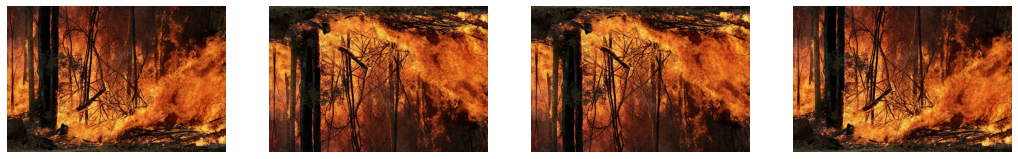

In [30]:
data_generator = ImageDataGenerator(vertical_flip=True)
plot(data_generator)

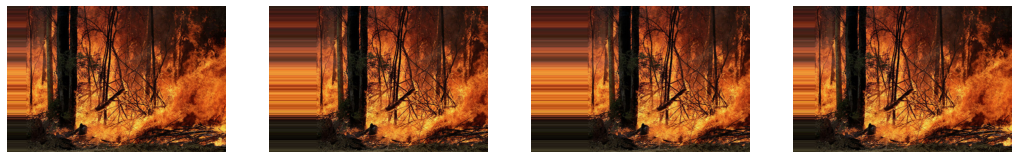

In [31]:
# nearest - по умолчанию
data_generator = ImageDataGenerator(width_shift_range=0.3, fill_mode='nearest')
plot(data_generator)

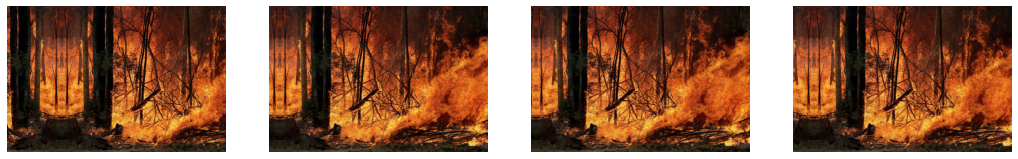

In [32]:
#Отражение
data_generator = ImageDataGenerator(width_shift_range=0.3, fill_mode='reflect')
plot(data_generator)

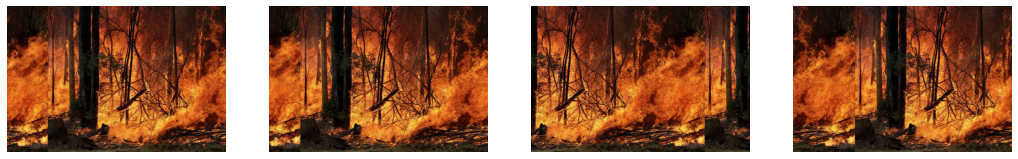

In [33]:
data_generator = ImageDataGenerator(width_shift_range=0.3, fill_mode='wrap')
plot(data_generator)

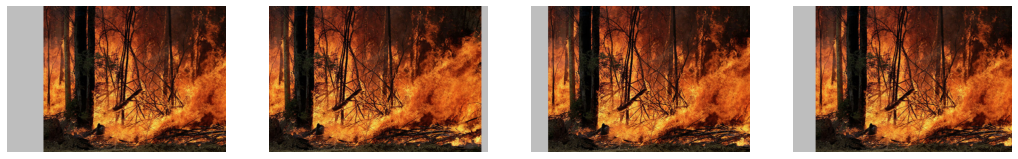

In [34]:
data_generator = ImageDataGenerator(width_shift_range=0.3, 
                                    fill_mode='constant', 
                                    cval=190)
plot(data_generator)

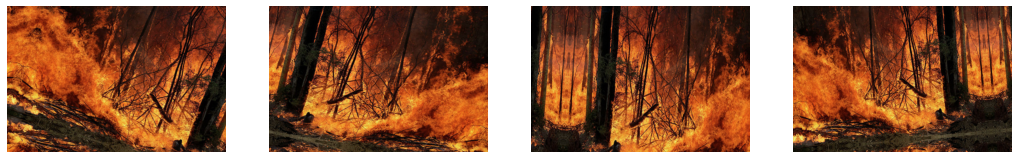

In [35]:
# дополнительные обучающие данные
datagen = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="reflect")
plot(datagen)

## Обучение

In [36]:
EPOCHS = 55
#Размер минивыборки,
BATCH_SIZE = 64  # изменяем веса нейронных сетей после того, как обрабатываем каждые __ объекта
# начальная скорость обучения
SPEED = 0.01 #0.01 = 1e-2 , подобрали по графику из другого ноутбука для 64, для 128- 0.1

In [37]:
# компиляция сети
model.compile(loss="binary_crossentropy", 
               optimizer=SGD(lr=SPEED, momentum=0.9, decay= SPEED / EPOCHS),
              metrics=["accuracy"])

In [38]:
# # информация о сети
# print(model.summary())

In [39]:
x_train.shape # изображения размеров 128 на 128 RGB

(3328, 128, 128, 3)

In [40]:
x_train.shape[0] #количество изображений для обучения, 25 процентов выделено под валидацию

3328

In [41]:
y_train.shape # 2 класса

(3328, 2)

In [42]:
x_train.shape[0] // BATCH_SIZE

52

In [43]:
# Обучение
history = model.fit_generator(
              datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
              steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(x_val, y_val), 
              class_weight=classWeight,
              shuffle =True,
              verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 52 steps, validate on 832 samples
Epoch 1/55
52/52 [==============================] - 334s 6s/step - loss: 0.7262 - accuracy: 0.7160 - val_loss: 9.3460 - val_accuracy: 0.3906
Epoch 2/55
52/52 [==============================] - 290s 6s/step - loss: 0.5008 - accuracy: 0.7882 - val_loss: 6.7492 - val_accuracy: 0.3906
Epoch 3/55
52/52 [==============================] - 291s 6s/step - loss: 0.3875 - accuracy: 0.8498 - val_loss: 1.4584 - val_accuracy: 0.5288
Epoch 4/55
52/52 [==============================] - 273s 5s/step - loss: 0.3559 - accuracy: 0.8594 - val_loss: 0.3783 - val_accuracy: 0.8377
Epoch 5/55
52/52 [==============================] - 279s 5s/step - loss: 0.3149 - accuracy: 0.8798 - val_loss: 0.2799 - val_accuracy: 0.8750
Epoch 6/55
52/52 [==============================] - 266s 5s/step - loss: 0.3081 - accuracy: 0.8687 - val_loss: 0.5341 - val_accuracy: 0.8101
Epoch 7/5

## Оценка качества обучения сети

In [44]:
qual = model.evaluate(x_val, y_val, verbose=0)
print("Точность работы на валидационных данных: %.2f%%" % (qual[1]*100))

Точность работы на валидационных данных: 97.00%


## Сохранение обученной сети

In [45]:
#сохранить модель
model.save("C:/Users/Marinka/Desktop/pract/fire-detection/FireDetection.h5")

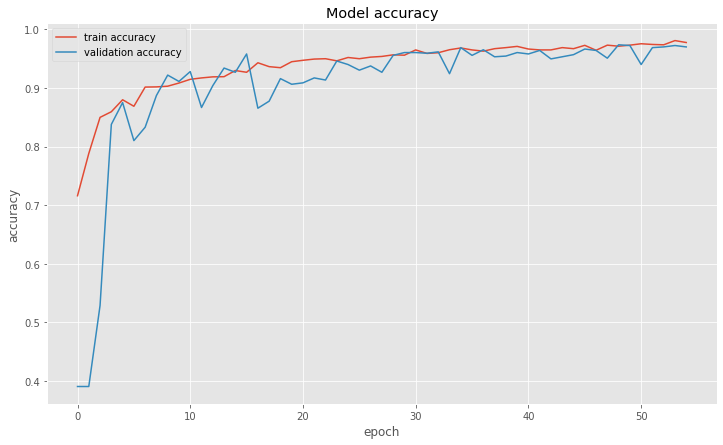

In [46]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot") 
plt.figure(figsize=(12,7))
plt.plot(N, history.history["accuracy"], label="train accuracy")
plt.plot(N, history.history["val_accuracy"], label="validation accuracy")
plt.title("Model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend() # для того, чтобы было в правом нижнем углу можно добавить это в скобки loc="lower right"
plt.show()

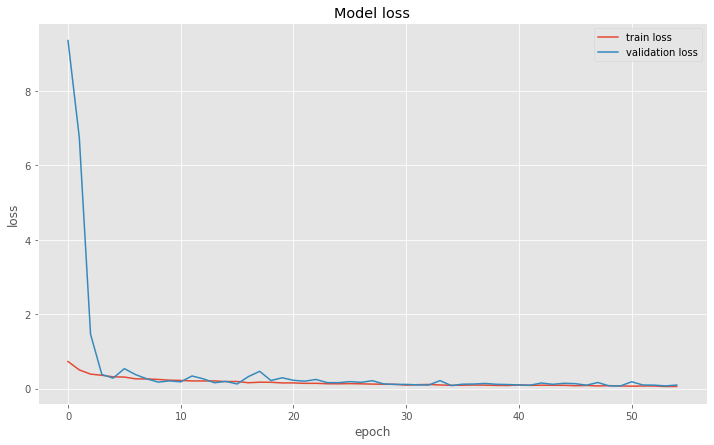

In [47]:
plt.figure(figsize=(12,7))
plt.plot(N, history.history["loss"], label="train loss")
plt.plot(N, history.history["val_loss"], label="validation loss")
plt.title("Model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

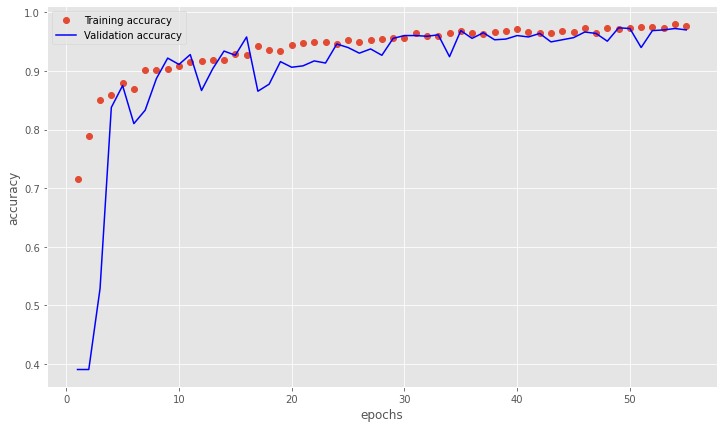

In [48]:
plt.figure(figsize=(12,7))
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'o', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()